In [14]:
import numpy as np
import sklearn
import sklearn.model_selection
from sklearn import tree
from imblearn.combine import SMOTEENN
import graphviz
from graphviz import Source
from IPython.display import Image

# Why this notebook?

The purpose of this notebook is to provide a quick, hands-on introduction to a more complete work regarding the prediction of the presence or absence of a NOX-like gene in *Escherichia coli*. 

We will be working on a small fraction of an array made of 17144 columns (number of organisms) and 117262 (clusters of genes). We will use all the columns, but only a thousand rows. 

The goal here is to understand how the full programm works. Therefore, the results won't be really informative (since we only use a portion of the clusters.)

#  Partition of the array

In this part, we will be creating the array using numpy. Beware, the resulting array is not "clean" (we don't delete the non-informative rows here).

In [3]:
def partition():
    fileMatrixPresenceAbsence = "./NOX_ecoli_data/all_ecoli_presence_absence_matrix.tsv"
    with open(fileMatrixPresenceAbsence) as f:
        #reads the first line to skip it
        f.readline()
        ligne = f.readline().rstrip()
        matrix = []
        t = ligne.split("\t")
        #We don't need the first column
        matrix.append(t[1:])
        #featuresNames contains the number associated with each cluster (to link the row and the matching cluster's number)
        featuresNames=[]
        featuresNames.append("Cluster n°"+t[0])
        while(ligne):            
            t=ligne.split("\t")
            #nombredelignes is the number de rows in the array on which we'll work (the execution time increases with that number)
            nombreDeLignes=1000
            
            if(len(matrix)<nombreDeLignes):
                matrix.append(t[1:])                
                featuresNames.append("Cluster n°"+t[0])
            #We need to retrieve the row containing Nox since we don't go that far in the array in this notebook
            if(t[0]=="26583"):
                noxCluster=t[1:]
                data = np.array(matrix).transpose()
                #We use the transpose because of a dimension issue we'll face later 
                return (data, noxCluster, featuresNames)
            ligne = f.readline().rstrip()
    

data = partition()
matrix = data[0]
nox = data[1]
featuresNames = data[2]

#  Preprocessing and training the data

We will now prepare the data so that we can use it with scikit-learn. Our data is imbalanced, so we'll use a mix of oversampling and undersampling with SMOTEENN. 

In [4]:
# Creation of the two subsets needed 

#Transformation of the lists of strings to lists of integers 
y = list(map(int,data[1]))
#x = np.delete(data[0], 26582, 1)
x=[]

# Transformation of the lists of strings to lists of integers
for tab in data[0]:
    x.append(list(map(int,tab)))
#We need len(x[0])==len(y)
print("taille x[0]:",np.array(x).shape)
print("taille y : ",np.array(y).shape)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 100)


# Resolving the imbalanced dataset issue
comb_samp = SMOTEENN()


# Training the data
x_comb, y_comb = comb_samp.fit_sample(x_train, y_train)

taille x[0]: (17144, 1000)
taille y :  (17144,)


#  Testing the data with a Decision Tree Classifier

We will use the DecisionTreeClassifier from the sklearn.tree tools. The criterion used is the information gain (entropy). 

In [5]:
classifier_entropy = sklearn.tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100)
classifier_entropy.fit(x_comb, y_comb)

y_pred = classifier_entropy.predict(x_test)

#Prints the accuracy of the model's prediction
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(str(accuracy*100)+"% accuracy.")

96.65629860031105% accuracy.


#  Graphic representation

Now that we have used the DecisionTreeClassifier tool, let's make (and see) a graphic representation of what we have done here. We will use graphviz for this purpose, as it is visually easier to read. 

With the complete program, the script is used in a shell. 
If the png file isn't automatically created from the dot file, we need to write the following command in the shell: 

```bash
dot -T png <fichier.dot> -o <fichier.png>
```

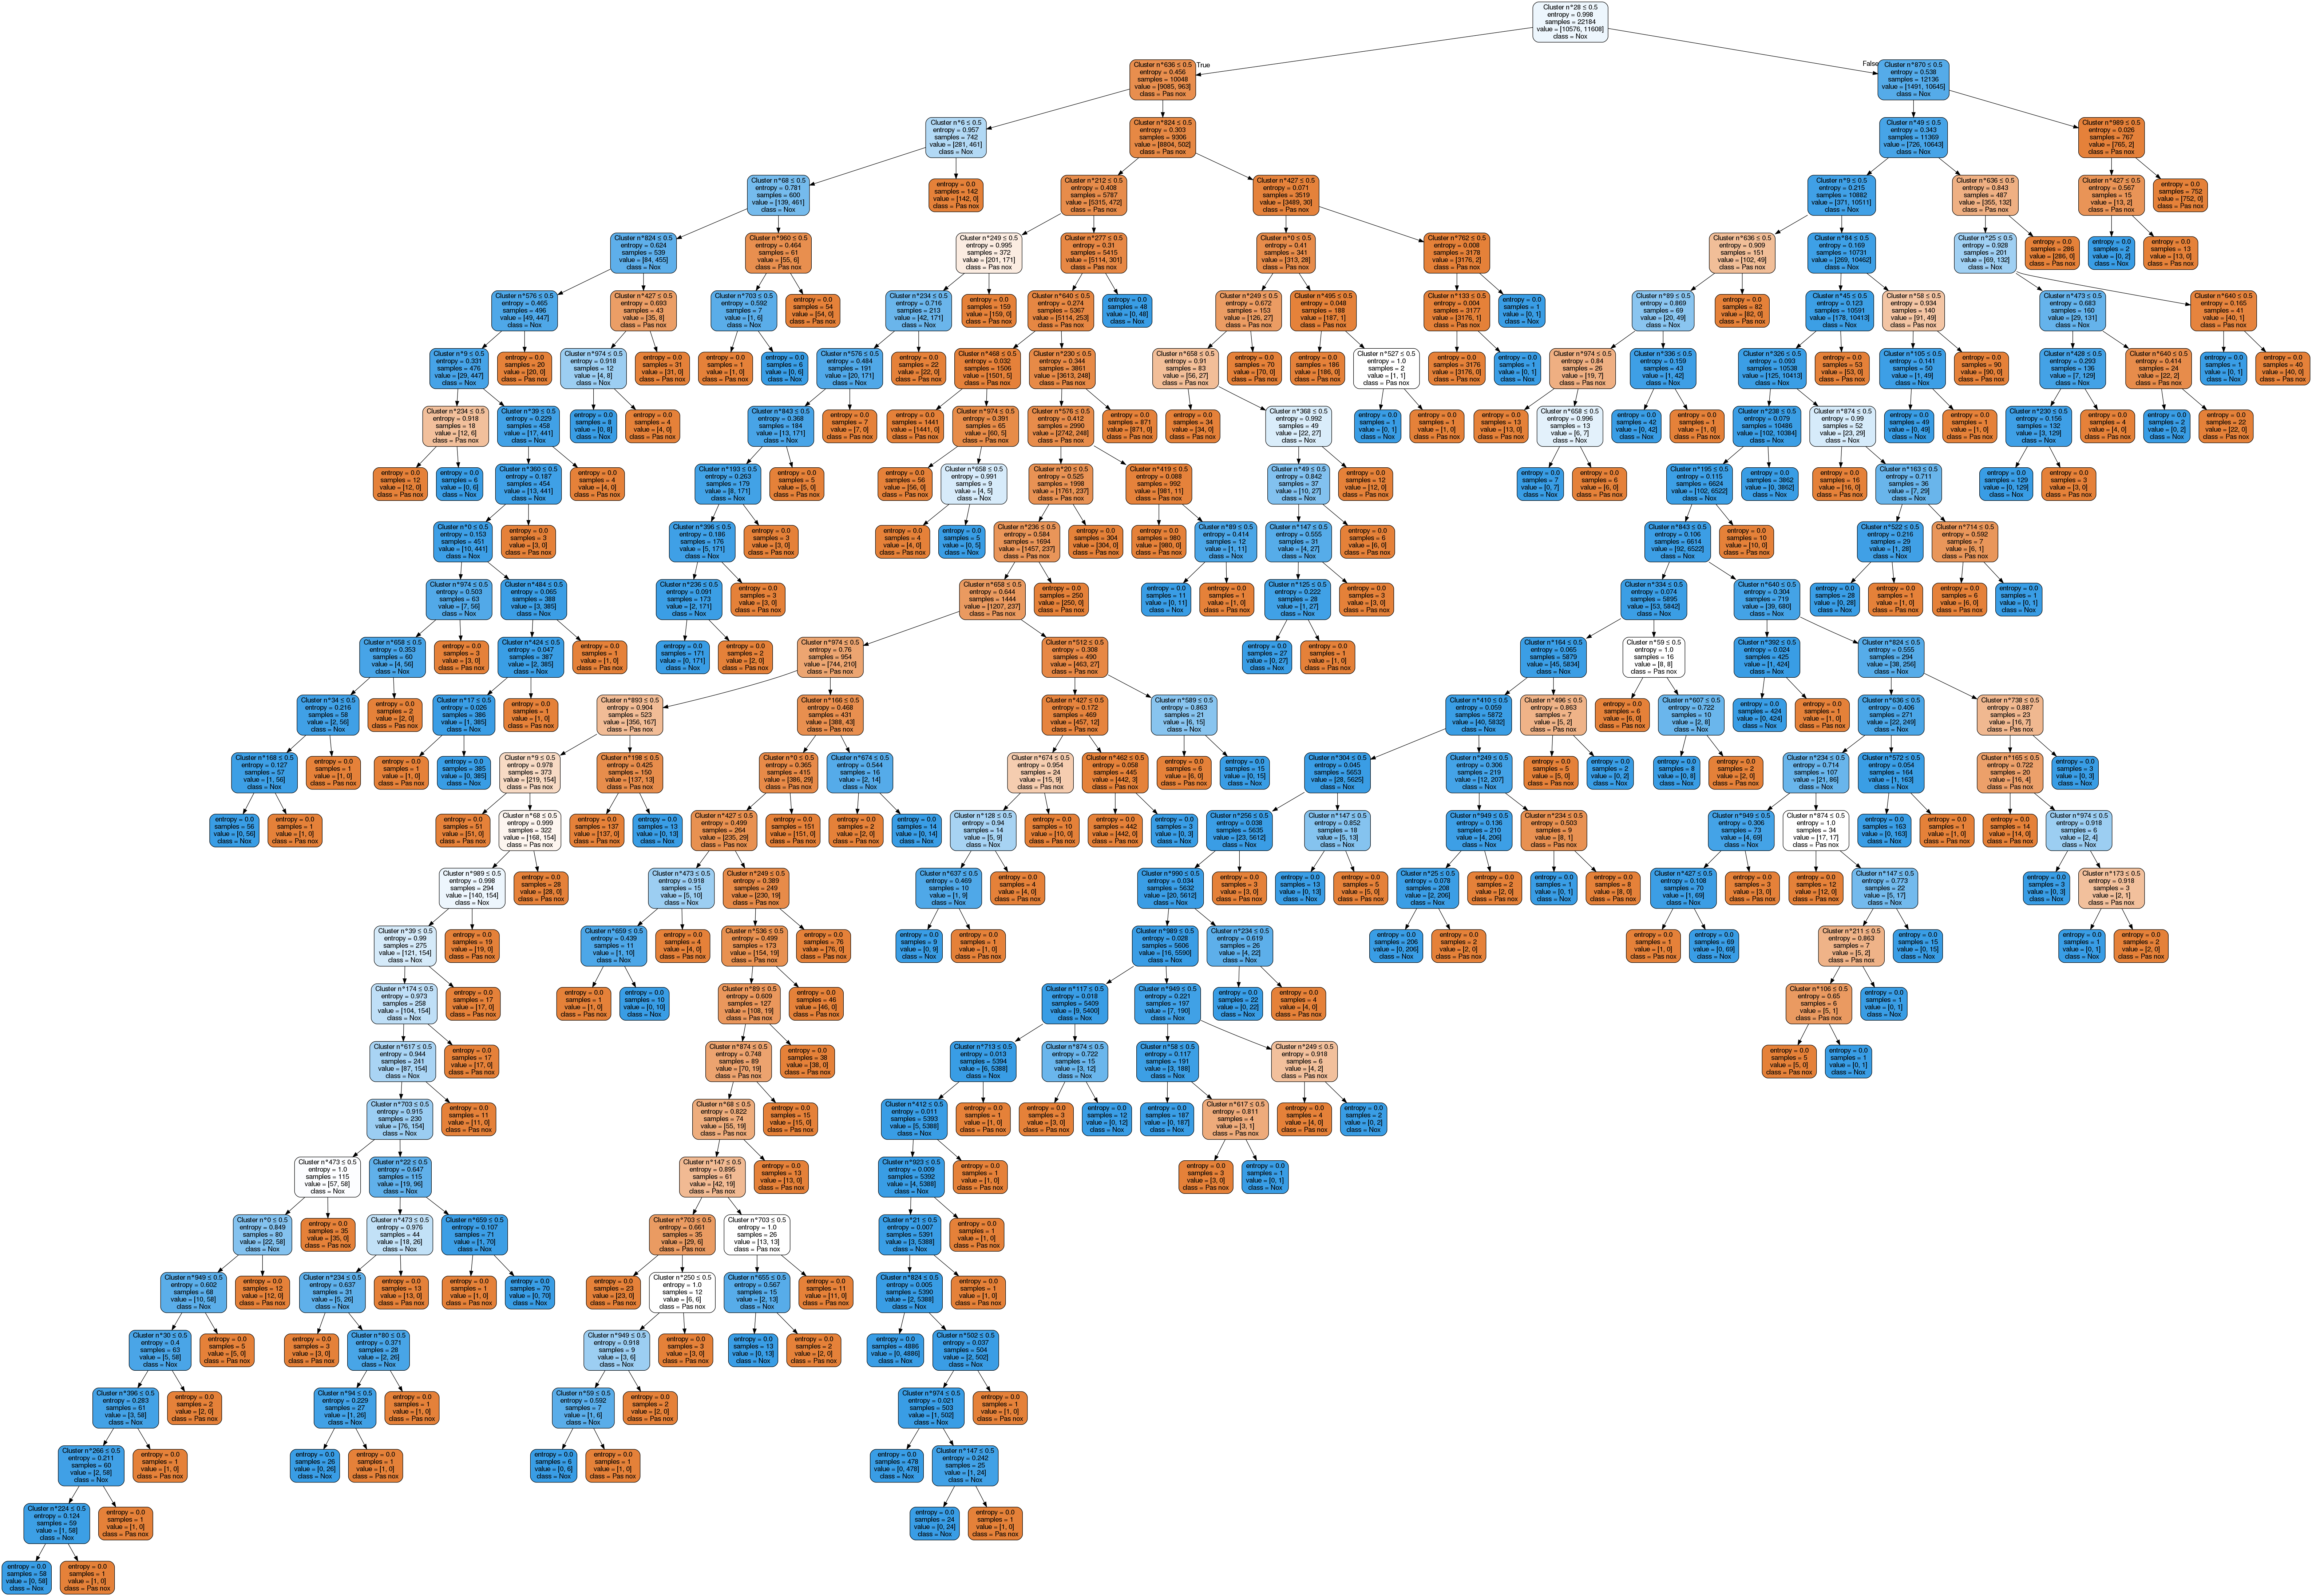

In [16]:
# Creation of a dot file that contains the graphic representation of our decision tree

#The following command is different in the more complete script. 
graph = Source(tree.export_graphviz(classifier_entropy, out_file=None ,feature_names=data[2],class_names=["Pas nox","Nox"],filled=True, rounded=True,special_characters=True))

 
# To visualize the resulting png file
png1000_file = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png1000_file)

Image(png1000_file)
